In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

from sklearn import metrics
from sklearn import svm
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

from scipy import stats

from datetime import datetime

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

In [109]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer

In [110]:
train = pd.read_csv("./data/train.csv")
print(train.shape)

#删除所有SALE PRICE为0的行
print(train[train["SALE PRICE"] == 0].shape)
train = train[train["SALE PRICE"] != 0]

""" #删除所有YEAR BUILT为0的行
print(train[train["YEAR BUILT"] == 0].shape)
train = train[train["YEAR BUILT"] != 0] """

train_y = train[["SALE PRICE"]]
train_X = train

test_X = pd.read_csv("./data/test.csv")
test_y = pd.read_csv("./data/test_groundtruth.csv")

print("train_X:",train_X.shape)
print("train_y:",train_y.shape)
print("test_X:",test_X.shape)
print("test_y:",test_y.shape)

(43064, 20)
(0, 20)
train_X: (43064, 20)
train_y: (43064, 1)
test_X: (10767, 19)
test_y: (10767, 1)


In [111]:
train.head(5)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,UPPER EAST SIDE (79-96),13 CONDOS - ELEVATOR APARTMENTS,2,1569,1027,R4,402 EAST 90TH STREET,5A,10128,1,0,1,-,-,1910,2,R4,1200000,2016-09-30 00:00:00
1,4,HOLLISWOOD,10 COOPS - ELEVATOR APARTMENTS,2,10538,70,D4,"87-50 204TH STREET, B42",,11423,0,0,0,-,-,1954,2,D4,120000,2017-02-10 00:00:00
2,3,DOWNTOWN-FULTON MALL,13 CONDOS - ELEVATOR APARTMENTS,2,170,1042,R4,265 STATE STREET,910,11201,1,0,1,0,0,2014,2,R4,1578287,2017-01-25 00:00:00
3,4,FLUSHING-NORTH,13 CONDOS - ELEVATOR APARTMENTS,2,4410,1023,R4,137-11 32 AVENUE,4W,11354,1,0,1,-,-,0,2,R4,510000,2017-03-17 00:00:00
4,3,PARK SLOPE,09 COOPS - WALKUP APARTMENTS,2C,1067,29,C6,"862 PRESIDENT STREET, 1",,11215,0,0,0,0,0,1920,2,C6,1950000,2016-09-09 00:00:00


In [112]:
num_train_samples = len(train_X)

data_X = pd.concat([train_X, test_X])

# Data Pre Processing

In [113]:
# Let's delete some of the columns that we ** may not ** need
# 请注意 下面删除的特征很可能是有用的，合理的处理能够获得更为准确的预测模型，请探索所删除特征的使用
del data_X['ADDRESS']
del data_X['APARTMENT NUMBER']
del data_X['SALE DATE']
"""del data_X['BUILDING CLASS AT PRESENT']
del data_X['BUILDING CLASS AT TIME OF SALE']
del data_X['NEIGHBORHOOD']
del data_X['LAND SQUARE FEET']
del data_X['GROSS SQUARE FEET'] """

"del data_X['BUILDING CLASS AT PRESENT']\ndel data_X['BUILDING CLASS AT TIME OF SALE']\ndel data_X['NEIGHBORHOOD']\ndel data_X['LAND SQUARE FEET']\ndel data_X['GROSS SQUARE FEET'] "

In [114]:
# 将无法转换为数字的字符串转换为NaN
def convert_to_number(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

data_X['LAND SQUARE FEET'] = data_X['LAND SQUARE FEET'].map(convert_to_number)
data_X['GROSS SQUARE FEET'] = data_X['GROSS SQUARE FEET'].map(convert_to_number)
data_X['YEAR BUILT'] = data_X['YEAR BUILT'].map(convert_to_number)

data_X['LAND SQUARE FEET'].replace(0, np.nan, inplace=True)
data_X['GROSS SQUARE FEET'].replace(0, np.nan, inplace=True)
data_X['YEAR BUILT'].replace(0, np.nan, inplace=True)

# 按NEIGHBORHOOD的中位数填充，如果某个NEIGHBORHOOD的所有LAND SQUARE FEET、GROSS SQUARE FEET或YEAR BUILT数据都是缺失的，则使用全局中位数填充
data_X['LAND SQUARE FEET'] = data_X.groupby('NEIGHBORHOOD')['LAND SQUARE FEET'].transform(
    lambda x: x.fillna(x[x>0].median()) if x[x>0].median() >= 0 
                                        else data_X['LAND SQUARE FEET'][data_X['LAND SQUARE FEET']>0].median())
data_X['GROSS SQUARE FEET'] = data_X.groupby('NEIGHBORHOOD')['GROSS SQUARE FEET'].transform(
    lambda x: x.fillna(x[x>0].median()) if x[x>0].median() >= 0 
                                        else data_X['GROSS SQUARE FEET'][data_X['GROSS SQUARE FEET']>0].median())
data_X['YEAR BUILT'] = data_X.groupby('NEIGHBORHOOD')['YEAR BUILT'].transform(
    lambda x: x.fillna(x[x>0].median()) if x[x>0].median() >= 0 
                                        else data_X['YEAR BUILT'][data_X['YEAR BUILT']>0].median())
    

# 数据类型转换
data_X['LAND SQUARE FEET'] = data_X['LAND SQUARE FEET'].astype(np.int64)
data_X['GROSS SQUARE FEET'] = data_X['GROSS SQUARE FEET'].astype(np.int64)
data_X['YEAR BUILT'] = data_X['YEAR BUILT'].astype(np.int64)
#data_X['HOUSE AGE'] = 2017 - data_X['YEAR BUILT']
#data_X['HAS_APARTMENT_NUMBER'] = ~data_X['APARTMENT NUMBER'].isnull()


In [115]:
Neighbor_Group = data_X.groupby(['NEIGHBORHOOD'])[['SALE PRICE']].agg(['median'])
Neighbor_Dict = dict(dict(Neighbor_Group[('SALE PRICE', 'median')]))
Borough_Group = data_X.groupby(['BOROUGH'])[['SALE PRICE']].agg(['median'])
Borough_Dict = dict(Borough_Group[('SALE PRICE', 'median')])
BCP_Group = data_X.groupby(['BUILDING CLASS AT PRESENT'])[['SALE PRICE']].agg(['median'])
BCP_Dict = dict(BCP_Group[('SALE PRICE', 'median')])
BCA_Group = data_X.groupby(['BUILDING CLASS AT TIME OF SALE'])[['SALE PRICE']].agg(['median'])
BCA_Dict = dict(BCA_Group[('SALE PRICE', 'median')])
TCP_Group = data_X.groupby(['TAX CLASS AT PRESENT'])[['SALE PRICE']].agg(['median'])
TCP_Dict = dict(TCP_Group[('SALE PRICE', 'median')])
TCA_Group = data_X.groupby(['TAX CLASS AT TIME OF SALE'])[['SALE PRICE']].agg(['median'])
TCA_Dict = dict(TCA_Group[('SALE PRICE', 'median')])

""" Neighbor_Group = data_X.groupby(['NEIGHBORHOOD'])[['SALE PRICE']].agg(['mean'])
Neighbor_Dict = dict(dict(Neighbor_Group[('SALE PRICE', 'mean')]))
Borough_Group = data_X.groupby(['BOROUGH'])[['SALE PRICE']].agg(['mean'])
Borough_Dict = dict(Borough_Group[('SALE PRICE', 'mean')])
BCP_Group = data_X.groupby(['BUILDING CLASS AT PRESENT'])[['SALE PRICE']].agg(['mean'])
BCP_Dict = dict(BCP_Group[('SALE PRICE', 'mean')])
BCA_Group = data_X.groupby(['BUILDING CLASS AT TIME OF SALE'])[['SALE PRICE']].agg(['mean'])
BCA_Dict = dict(BCA_Group[('SALE PRICE', 'mean')])
TCP_Group = data_X.groupby(['TAX CLASS AT PRESENT'])[['SALE PRICE']].agg(['mean'])
TCP_Dict = dict(TCP_Group[('SALE PRICE', 'mean')])
TCA_Group = data_X.groupby(['TAX CLASS AT TIME OF SALE'])[['SALE PRICE']].agg(['mean'])
TCA_Dict = dict(TCA_Group[('SALE PRICE', 'mean')]) """

data_X["oNeighborhood"] = data_X["NEIGHBORHOOD"].map(Neighbor_Dict).fillna(1).apply(np.log)
data_X["oBOR"] = data_X["BOROUGH"].map(Borough_Dict).fillna(1).apply(np.log)
data_X["oBCA"] = data_X["BUILDING CLASS AT TIME OF SALE"].map(BCA_Dict).fillna(1).apply(np.log)
data_X["oBCP"] = data_X["BUILDING CLASS AT PRESENT"].map(BCP_Dict).fillna(1).apply(np.log)
data_X["oTCA"] = data_X["BUILDING CLASS AT TIME OF SALE"].map(TCA_Dict).fillna(1).apply(np.log)
data_X["oTCP"] = data_X["BUILDING CLASS AT PRESENT"].map(TCP_Dict).fillna(1).apply(np.log)


""" data_X.drop(['BOROUGH'], axis=1, inplace=True)
data_X.drop(['BUILDING CLASS AT TIME OF SALE'], axis=1, inplace=True)
data_X.drop(['BUILDING CLASS AT PRESENT'], axis=1, inplace=True)
data_X.drop(['NEIGHBORHOOD'], axis=1, inplace=True) """

" data_X.drop(['BOROUGH'], axis=1, inplace=True)\ndata_X.drop(['BUILDING CLASS AT TIME OF SALE'], axis=1, inplace=True)\ndata_X.drop(['BUILDING CLASS AT PRESENT'], axis=1, inplace=True)\ndata_X.drop(['NEIGHBORHOOD'], axis=1, inplace=True) "

In [116]:
NumStr = [
    "YEAR BUILT",
    "TAX CLASS AT PRESENT",
    "TAX CLASS AT TIME OF SALE",
    "BUILDING CLASS CATEGORY",
    ]
for col in NumStr:
    data_X[col] = data_X[col].astype(str)

<Axes: xlabel='YEAR BUILT', ylabel='NEIGHBORHOOD'>

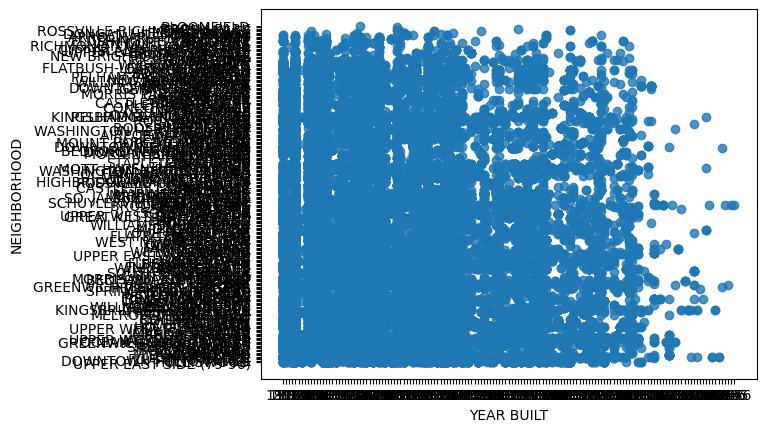

In [117]:
sns.regplot(x=data_X['YEAR BUILT'], y=data_X['NEIGHBORHOOD'], fit_reg=False)

In [118]:
data_X.drop(['SALE PRICE'], axis=1, inplace=True)

In [119]:
# Let's convert some of the columns to appropriate datatype

data_X['TAX CLASS AT TIME OF SALE'] = data_X['TAX CLASS AT TIME OF SALE'].astype('category')
data_X['TAX CLASS AT PRESENT'] = data_X['TAX CLASS AT PRESENT'].astype('category')
data_X['BUILDING CLASS CATEGORY'] = data_X['BUILDING CLASS CATEGORY'].astype('category')
data_X['BOROUGH'] = data_X['BOROUGH'].astype('category')
data_X['BUILDING CLASS AT PRESENT'] = data_X['BUILDING CLASS AT PRESENT'].astype('category')
data_X['BUILDING CLASS AT TIME OF SALE'] = data_X['BUILDING CLASS AT TIME OF SALE'].astype('category')
data_X['NEIGHBORHOOD'] = data_X['NEIGHBORHOOD'].astype('category')

In [120]:
data_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53831 entries, 0 to 10766
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         53831 non-null  category
 1   NEIGHBORHOOD                    53831 non-null  category
 2   BUILDING CLASS CATEGORY         53831 non-null  category
 3   TAX CLASS AT PRESENT            53831 non-null  category
 4   BLOCK                           53831 non-null  int64   
 5   LOT                             53831 non-null  int64   
 6   BUILDING CLASS AT PRESENT       53831 non-null  category
 7   ZIP CODE                        53831 non-null  int64   
 8   RESIDENTIAL UNITS               53831 non-null  int64   
 9   COMMERCIAL UNITS                53831 non-null  int64   
 10  TOTAL UNITS                     53831 non-null  int64   
 11  LAND SQUARE FEET                53831 non-null  int64   
 12  GROSS SQUARE FEET 

In [121]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YEAR BUILT"] = lab.fit_transform(X["YEAR BUILT"])
        #X["BOROUGH"] = lab.fit_transform(X["BOROUGH"])
        return X

In [122]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        required_columns = ["RESIDENTIAL UNITS", "COMMERCIAL UNITS", "LAND SQUARE FEET", "GROSS SQUARE FEET", "YEAR BUILT"]
        for col in required_columns:
            if col not in X.columns:
                raise ValueError(f"Missing expected column: {col}")

        X["RESIDENTIAL UNITS"].replace(0, np.nan, inplace=True)
        X["COMMERCIAL UNITS"].replace(0, np.nan, inplace=True)

        X["AVERAGE LAND PER RESIDENTIAL UNIT"] = X["LAND SQUARE FEET"] / X["RESIDENTIAL UNITS"]
        X["AVERAGE GROSS SQUARE FEET PER RESIDENTIAL UNIT"] = X["GROSS SQUARE FEET"] / X["RESIDENTIAL UNITS"]
        X["AVERAGE LAND PER COMMERCIAL UNIT"] = X["LAND SQUARE FEET"] / X["COMMERCIAL UNITS"]
        X["AVERAGE GROSS SQUARE FEET PER COMMERCIAL UNIT"] = X["GROSS SQUARE FEET"] / X["COMMERCIAL UNITS"]

        # Create a feature for the age of the building at the time of the sale
        X["BUILDING AGE"] = X["YEAR BUILT"].apply(lambda x: 2023 - int(x) if x != 0 else np.nan)

        # Create a feature for the total number of units
        X["TOTAL UNITS"] = X["RESIDENTIAL UNITS"] + X["COMMERCIAL UNITS"]

        # Create polynomial features
        X["RESIDENTIAL UNITS SQUARED"] = X["RESIDENTIAL UNITS"] ** 2
        X["COMMERCIAL UNITS SQUARED"] = X["COMMERCIAL UNITS"] ** 2
        X["TOTAL UNITS SQUARED"] = X["TOTAL UNITS"] ** 2

        # New features
        X["RESIDENTIAL TO COMMERCIAL RATIO"] = X["RESIDENTIAL UNITS"] / (X["COMMERCIAL UNITS"] + 1)  # add 1 to avoid dividing by zero
        X["BUILDING AGE SQUARED"] = X["BUILDING AGE"] ** 2

        # Replace inf and -inf with nan (resulted from division by zero)
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Replace nan with 0 (If you want to replace with mean or median of the column, you can do that)
        X.fillna(0, inplace=True)

        return X


In [123]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x)) 
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [124]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature()), 
    ('skew_dummies', skew_dummies(skew=1)),
    ])    
""" """

' '

In [125]:
data_X.head(5)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,...,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,oNeighborhood,oBOR,oBCA,oBCP,oTCA,oTCP
0,1,UPPER EAST SIDE (79-96),13 CONDOS - ELEVATOR APARTMENTS,2,1569,1027,R4,10128,1,0,...,3141,1910,2,R4,13.814510,13.810080,13.810498,13.812279,0.0,0.0
1,4,HOLLISWOOD,10 COOPS - ELEVATOR APARTMENTS,2,10538,70,D4,11423,0,0,...,2055,1954,2,D4,12.301383,13.129305,12.971540,12.971540,0.0,0.0
2,3,DOWNTOWN-FULTON MALL,13 CONDOS - ELEVATOR APARTMENTS,2,170,1042,R4,11201,1,0,...,3300,2014,2,R4,14.240726,13.560618,13.810498,13.812279,0.0,0.0
3,4,FLUSHING-NORTH,13 CONDOS - ELEVATOR APARTMENTS,2,4410,1023,R4,11354,1,0,...,1654,1962,2,R4,13.540566,13.129305,13.810498,13.812279,0.0,0.0
4,3,PARK SLOPE,09 COOPS - WALKUP APARTMENTS,2C,1067,29,C6,11215,0,0,...,3078,1920,2,C6,14.065880,13.560618,12.608199,12.608199,0.0,0.0


In [126]:
one_hot_features = ['BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE'
                    ,'BUILDING CLASS AT PRESENT','BUILDING CLASS AT TIME OF SALE','NEIGHBORHOOD']

one_hot_encoded = pd.get_dummies(data_X[one_hot_features])

data_X = data_X.drop(one_hot_features,axis=1)
data_X = pd.concat([data_X, one_hot_encoded] ,axis=1)

In [127]:
data_X_copy = data_X.copy()
data_pipe = pipe.fit_transform(data_X_copy)
scaler = RobustScaler()

n_train = train_X.shape[0]
X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y = train_y
X_scaled = scaler.fit(X).transform(X)
y_log = np.log(y)
test_X_scaled = scaler.transform(test_X)

In [128]:
""" lasso_cv = LassoCV(alphas=[0.0001, 0.00001, 0.000005, 0.000001], cv=5)
lasso_cv.fit(X_scaled, y_log.values.ravel())

print("Best alpha: ", lasso_cv.alpha_) """

# 使用最佳alpha进行Lasso回归
lasso = Lasso(alpha=0.00001)
lasso.fit(X_scaled, y_log)

Lasso(alpha=1e-05)

In [129]:
FI_lasso = pd.DataFrame({"Feature Importance": lasso.coef_}, index=data_pipe.columns)

In [130]:
FI_lasso.sort_values("Feature Importance", ascending=False)  # 利用Lasso计算出一个特征重要性的分数

,Feature Importance
NEIGHBORHOOD_GLEN OAKS,1.120701
NEIGHBORHOOD_BROOKLYN HEIGHTS,1.109969
NEIGHBORHOOD_RIVERDALE,0.955287
NEIGHBORHOOD_COBBLE HILL,0.949633
BUILDING CLASS AT TIME OF SALE_V0,0.849785
...,...
BUILDING CLASS CATEGORY_48 CONDO TERRACES/GARDENS/CABANAS,-0.927410
NEIGHBORHOOD_CO-OP CITY,-0.928243
BUILDING CLASS AT TIME OF SALE_RG,-0.955615
BUILDING CLASS CATEGORY_45 CONDO HOTELS,-0.961469


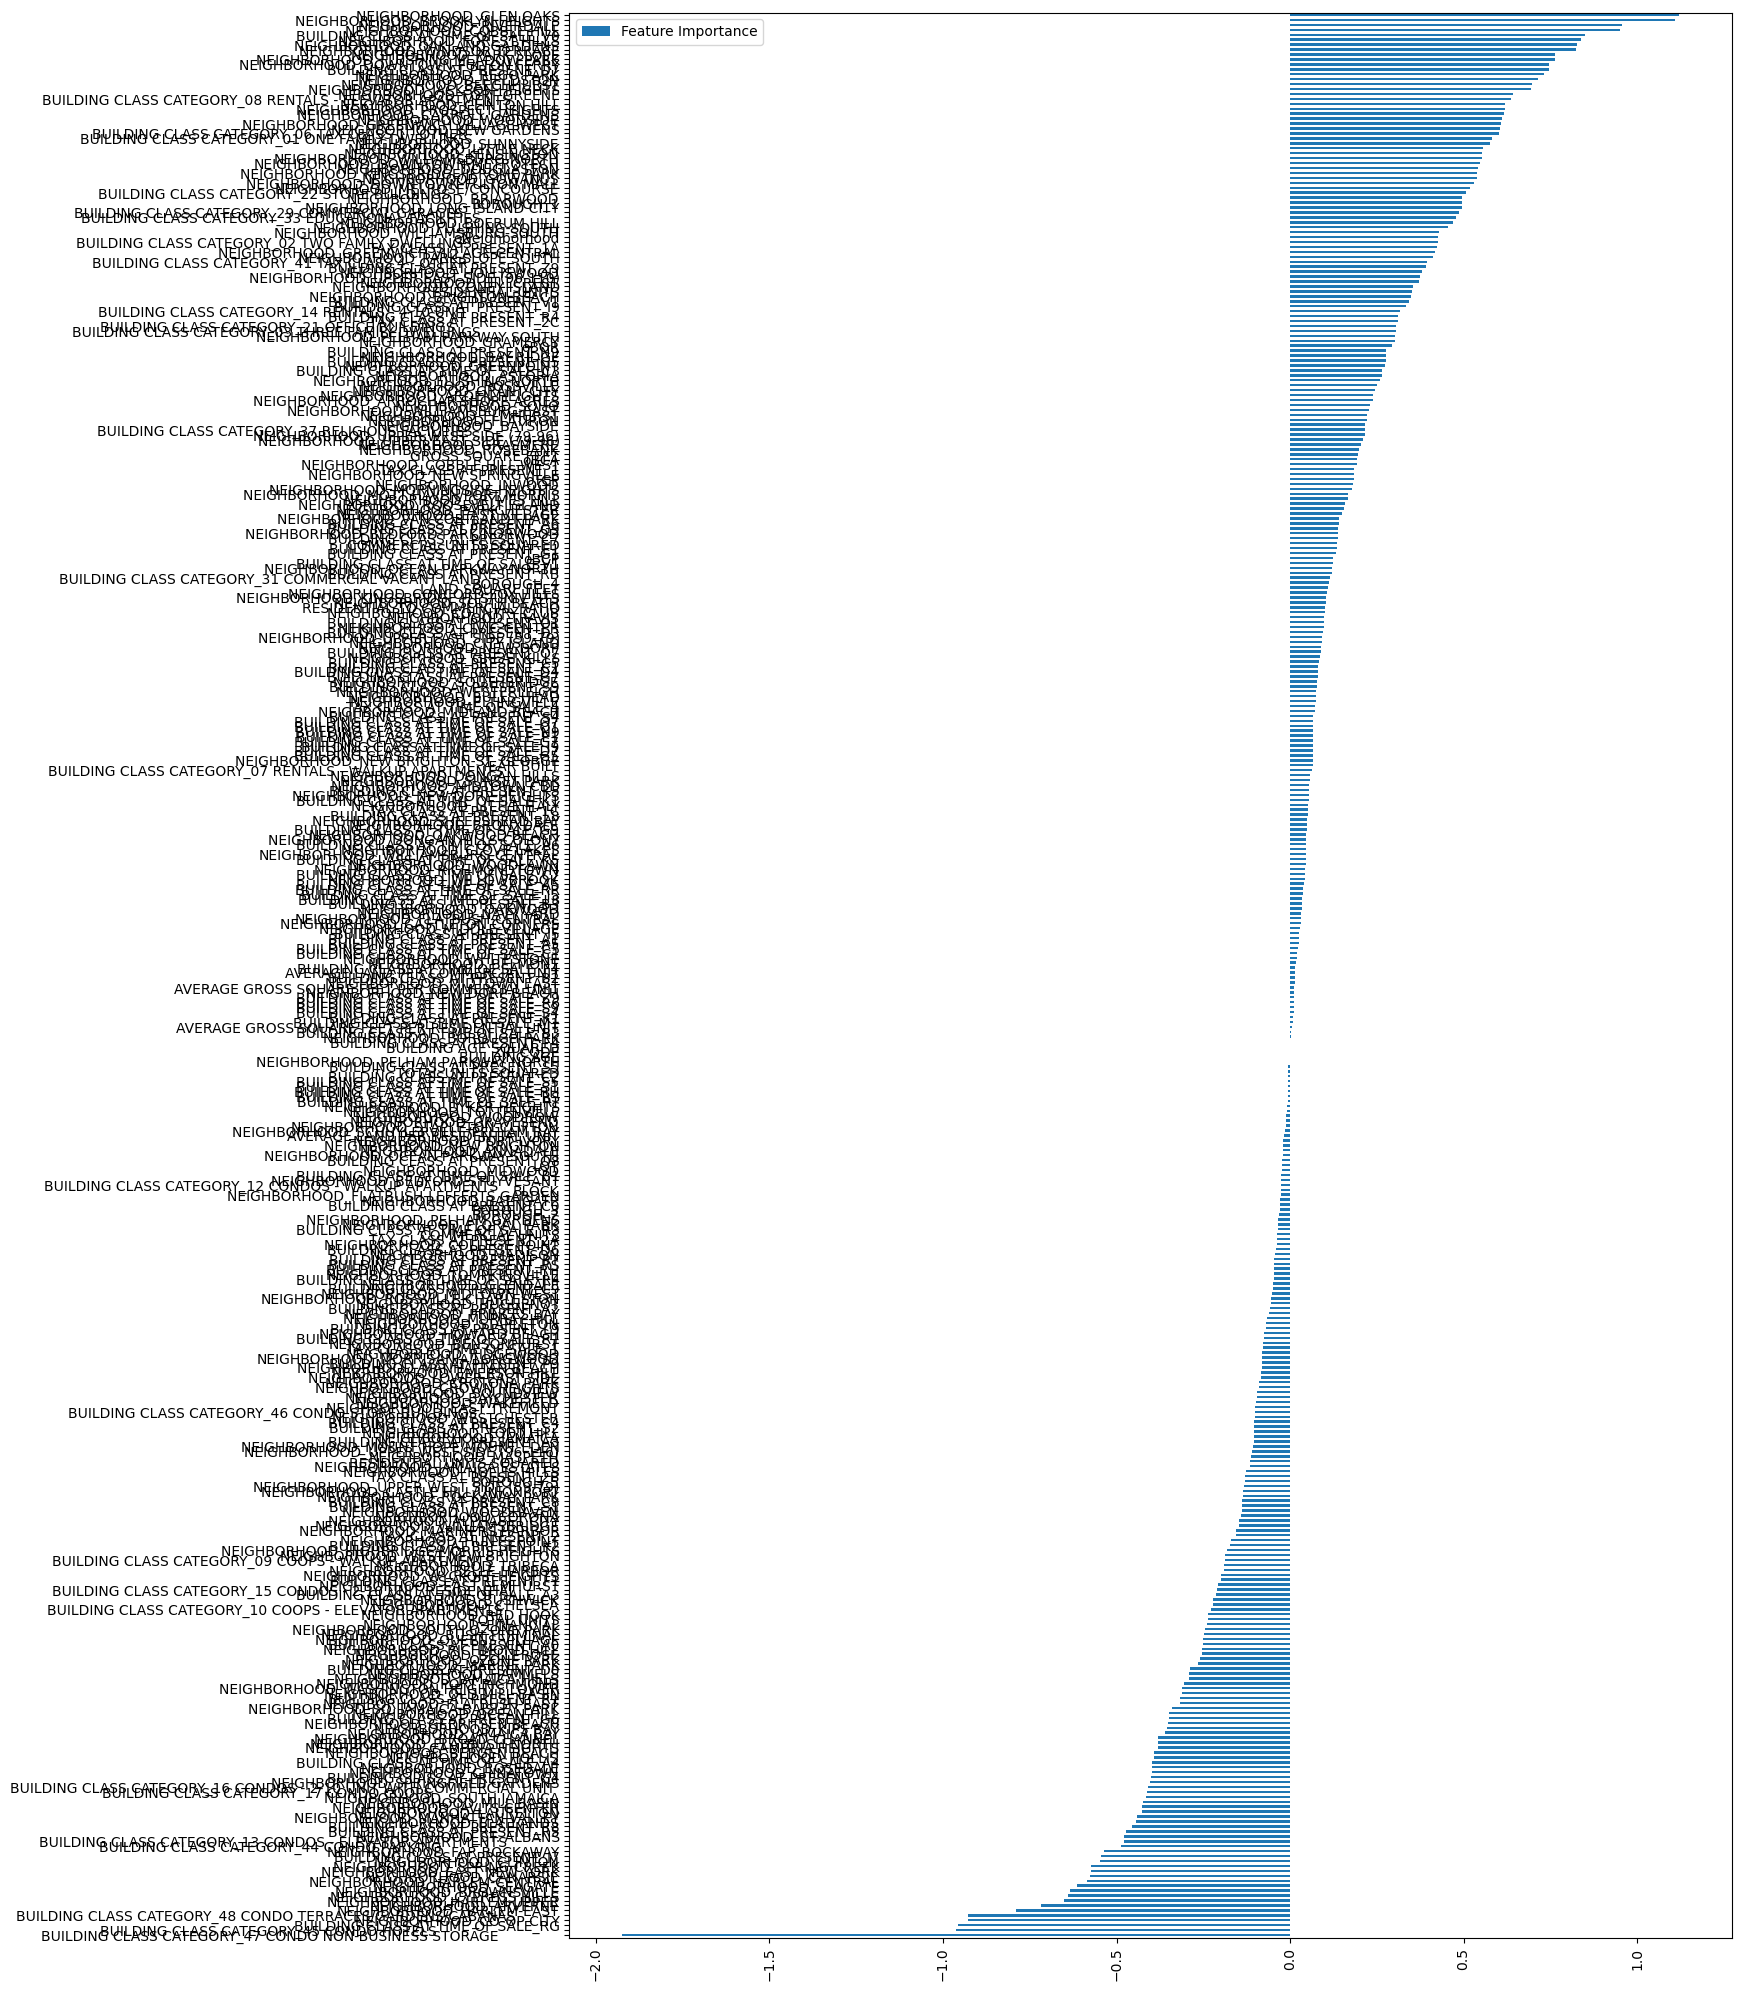

In [131]:
FI_lasso[FI_lasso["Feature Importance"] != 0].sort_values("Feature Importance").plot(kind="barh", figsize=(15, 25))
plt.xticks(rotation=90)
plt.show()  ### 更直观的可视化一下

# Regression

In [132]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self, mod, weight):
        self.mod = mod
        self.weight = weight

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X, y)
        return self

    def predict(self, X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model, data] * weight for model, weight in zip(range(pred.shape[0]), self.weight)]
            w.append(np.sum(single))
        return w

In [160]:
"""ls = Lasso(alpha=0.00001)
rg = Ridge(alpha=0.00001)
nnr = KNeighborsRegressor(n_neighbors=5)
cbr = CatBoostRegressor(n_estimators=200, verbose=0)
lgb = LGBMRegressor(n_estimators=200, n_jobs=-1)

 weight_avg = AverageWeight(mod=[xgb, rf, et, cbr, lgb, ls, rg, nnr],
                            weight=[0.38, 0.38, 0.18, 0.01, 0.01, 0.01, 0.01, 0.02])
weight_avg.fit(X_scaled, y_log.values.ravel())
y = weight_avg.predict(test_X_scaled)
y_pred = np.exp(y) """

xgb = XGBRegressor(n_estimators=170, learning_rate=0.025)
rf = RandomForestRegressor(n_estimators=170, bootstrap=True, max_features=0.5, max_depth=32, n_jobs=6)
et = ExtraTreesRegressor(n_estimators=170, bootstrap=True, max_features=0.5, max_depth=32, n_jobs=6)


weight_avg = AverageWeight(mod=[xgb, rf, et],
                            weight=[0.4, 0.4, 0.2])
weight_avg.fit(X_scaled, y_log.values.ravel())
y = weight_avg.predict(test_X_scaled)
y_pred = np.exp(y)

mean_absolute_percentage_error(test_y, y_pred)

0.30987879231241794

In [161]:
pd.DataFrame({"pred":y_pred}).to_csv("2200017416_康子熙.csv")